
# Tree-based Time Series Probabilistic forecasting - LightGBM, XGBoost, CatBoost

### Installation

In [1]:
#!pip install pandas numpy matplotlib darts lightgbm catboost

### Manual installation for Prophet, CatBoost, and LightGBM
You need to manually install the Prophet, CatBoost, and LightGBM packages because as of version 0.25.0, the default darts package does not install Prophet, CatBoost, and LightGBM dependencies.
- Prophet: Install the prophet package (version 1.1.1 or more recent) using the Prophet install guide
- CatBoostModel: Install the catboost package (version 1.0.6 or more recent) using the CatBoost install guide
- LightGBMModel: Install the lightgbm package (version 3.2.0 or more recent) using the LightGBM install guide

## (1) Data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# If you use Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = '/content/gdrive/My Drive/data/time_series'
# https://www.kaggle.com/datasets/yasserh/walmart-dataset

In [4]:
path = '/Users/chriskuo/Downloads/data'
data = pd.read_csv(path + '/walmart.csv', delimiter=",")
data['ds'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.index = data['ds']
data = data.drop('Date', axis=1)
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
ds,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05


In [5]:
data.dtypes

Store                    int64
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
ds              datetime64[ns]
dtype: object

In [6]:
from darts import TimeSeries
darts_group_df = TimeSeries.from_group_dataframe(data, group_cols='Store', time_col='ds')
print("The number of groups/stores is:", len(darts_group_df))
print("The number of time period is: ", len(darts_group_df[0]))

The number of groups/stores is: 45
The number of time period is:  143


In [7]:
darts_group_df[0].components

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object', name='component')

In [8]:
store1 = darts_group_df[0]
train = store1[:130]
test = store1[130:]
len(train), len(test) # (130, 13)

(130, 13)

In [9]:
target = train['Weekly_Sales']
past_cov = train[['Fuel_Price','CPI']]
future_cov = store1['Holiday_Flag'][:143]


#### Darts

- **lags_past_covariates** – Lagged past_covariates values used to predict the next time step/s.
- **lags_future_covariates** – Lagged future_covariates values used to predict the next time step/s.
- Let's explain lags_future_covariates:
    - **Future Covariates** - Covariates are additional variables, other than the target variable, that are used as features in a time series forecasting model. These covariates may provide additional information that can help improve the accuracy of forecasts. "Future covariates" refer to the values of these covariates at future time steps that are available for forecasting.
    - **Lagged Values** - "Lagged" values refer to the values of a variable (in this case, the future covariates) from previous time steps. Lagged values are often used in time series forecasting to capture temporal dependencies and patterns in the data. For example, if you're forecasting the value of a variable at time t, the lagged values of the covariates could be their values at time t-1, t-2, and so on.
    - So this means that for each time step in the future, the model considers the values of the covariates at previous time steps as features. It's "lagged" because it uses past values of the covariates, but it's "future" because it considers these lagged values for future time steps when making forecasts. This approach allows the model to incorporate both past information and future covariate values to make predictions, potentially capturing complex temporal relationships in the data.
- **n** - the forecast horizon for n periods in predict()
- **output_chunk_length** – Number of time steps predicted at once (per chunk) by the internal model.
    - It is important that n <= output_chunk_length to prevent auto-regression.
    - **Chunk-Based Prediction**: When making forecasts for a time series, the internal model may predict multiple future time steps simultaneously. Instead of predicting one time step at a time, the model can predict several consecutive time steps together. This approach is known as chunk-based prediction.
    - **Output Chunk Length**: The `output_chunk_length` parameter determines the number of time steps that the model predicts together in each chunk. For example, if `output_chunk_length` is set to 5, the model will predict the next 5 time steps at once. This means that instead of predicting just the next time step, the model predicts several future time steps in one go.
    - Chunk-based prediction can improve the efficiency of forecasting, especially when dealing with long time series or when using complex models. By predicting multiple time steps at once, the model can exploit temporal dependencies more effectively and potentially improve forecasting accuracy. Additionally, chunk-based prediction can reduce the computational overhead associated with making individual predictions for each time step.

- **multi_models** – If True, a separate model will be trained for each future lag to predict. If False, a single model is trained to predict at step ‘output_chunk_length’ in the future. Default: True.


## (2) LightGBM


### (2.1) LightGBM - point estimate

In [10]:
from darts.models import LightGBMModel
n = 12
model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred.values()

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L

array([[1648229.14360717],
       [1647585.15388686],
       [1569763.01141598],
       [1627100.35048412],
       [1679217.5866184 ],
       [1711997.88579476],
       [1678208.72099501],
       [1731293.24264894],
       [1554316.24884006],
       [1692049.51861498],
       [1546896.79482908],
       [1510526.78395763]])

Mean Absolute Error: 77818.15743357211
Mean Absolute Percentage Error 5.094914261560656


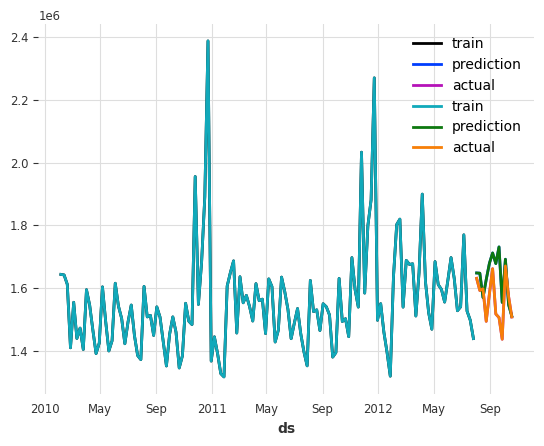

In [13]:
def plotit():
  import matplotlib.pyplot as plt
  target.plot(label = 'train')
  pred.plot(label = 'prediction')
  test['Weekly_Sales'][:n].plot(label = 'actual')

  from darts.metrics.metrics import mae, mape
  print("Mean Absolute Error:", mae(test['Weekly_Sales'][:n], pred))
  print("Mean Absolute Percentage Error", mape(test['Weekly_Sales'][:n], pred))
  plt.show()

plotit()

### (2.2) LightGBM - Quantile forecasts

In [14]:
n = 12
chunk_length = n
model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)> Size: 480B
array([[[1419015.6164711 , 1430530.94222635, 1536537.44312433,
         1540920.81365064, 1416759.98096915]],

       [[1473250.39942573, 1711092.80663488, 1666384.19995989,
         1651941.67309311, 1596216.77537442]],

       [[1629001.47977612, 1611736.35273311, 1531117.66916217,
         1485882.71801363, 1645347.68898223]],

       [[1691568.9450365 , 1614207.33490966, 1619266.02320231,
         1855147.77322143, 1419421.5004344 ]],

       [[1603984.9230746 , 1428141.45668558, 1383255.53717247,
         1697643.30314312, 1634146.66131969]],

       [[1636414.75348998, 1575808.76376679, 1569070.25446153,
         1729820.18499794, 1696129.86436785]],

       [[1689203.29881393, 1747459.4518502 , 1545458.4098802 ,
         1655810.36792731, 1571752.00401095]],

       [[1589708.20604832, 1679682.18969869, 1544761.18444242,
         1500091.54511061, 1675653.33071527]],

       [[1643278.01526344, 1615695.65975978, 1564110.82343906,
         1561299.67038686, 1610067.15564587]],

       [[1585675.27021826, 1527418.71415577, 1891364.15099831,
         1481044.04714346, 1632168.19856598]],

       [[1411475.93906954, 1564233.43219921, 1815430.41469448,
         1756058.52109848, 1492053.04500664]],

       [[1579099.07255574, 1643816.1796812 , 1597883.32235516,
         1498288.47921764, 1736612.30764889]]])
Coordinates:
  * ds         (ds) datetime64[ns] 96B 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 8B 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None
    metadata:           None

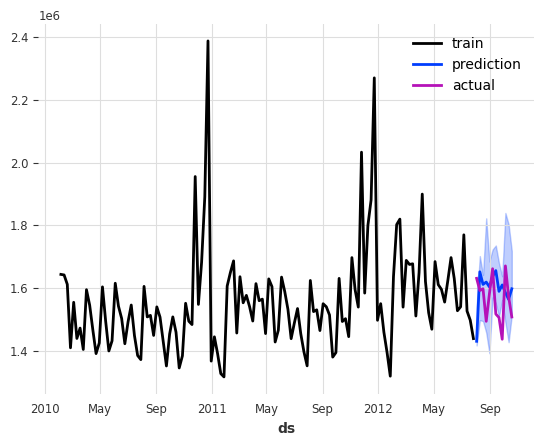

In [15]:
def plotQuantile():
    import matplotlib.pyplot as plt
    target.plot(label = 'train')
    pred.plot(label = 'prediction')
    test['Weekly_Sales'][:n].plot(label = 'actual')
    plt.show()
plotQuantile()

## (3) XGBM

### (3.1) XGBM - point estimate

In [16]:
from darts.models import XGBModel
n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

/opt/anaconda3/envs/book_ts_py311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:40:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)> Size: 48B
array([[[1534921. ]],

       [[1657664.1]],

       [[1601968.1]],

       [[1628613.1]],

       [[1702896. ]],

       [[1652600.6]],

       [[1881263.8]],

       [[1894230.5]],

       [[2021601.6]],

       [[1630586.6]],

       [[1535007.5]],

       [[1479447.8]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 96B 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 8B 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None
    metadata:           None

Mean Absolute Error: 156117.2025
Mean Absolute Percentage Error 10.382310080064425


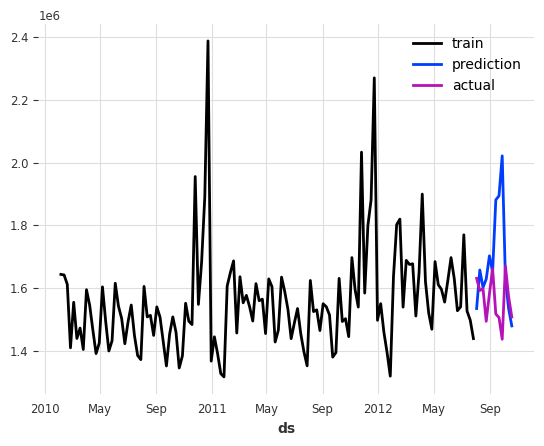

In [17]:
plotit()

### (3.2) XGBM - quantile forecasts

In [18]:
from darts.models import XGBModel
n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)> Size: 480B
array([[[1802314.91445624, 1624366.21366038, 1477006.78245901,
         1437020.61126029, 1341221.5       ]],

       [[1455415.21337648, 1613299.25347663, 1487101.97622152,
         1626892.23562367, 1672123.08879288]],

       [[1613423.94414192, 1550304.64249272, 1562538.7360184 ,
         1628898.05885882, 1362753.48793292]],

       [[1457707.54791227, 1583675.4513041 , 1718257.6921549 ,
         1586812.62954757, 1462072.48214052]],

       [[1693554.12634983, 1716659.89632534, 1704634.52104904,
         1427000.38088267, 1724340.87875246]],

       [[1676243.66318075, 1695638.77833346, 1684862.14354893,
         1638246.1281931 , 1655989.65556783]],

       [[1753893.56945571, 1755757.40531684, 1680108.75909221,
         1541460.78538388, 1665584.27680448]],

       [[1540987.97860947, 1697614.42749583, 1575120.05411362,
         1697865.89170304, 1704987.34861659]],

       [[1686071.93738496, 1691074.60763157, 1839524.19892688,
         1516935.99443859, 1507892.2488953 ]],

       [[1606935.36603267, 1686575.40061878, 1721299.76284542,
         1687293.80490807, 1537471.2461757 ]],

       [[1555141.59747335, 1623677.64133065, 1602006.10951173,
         1598689.69402158, 1683621.21959431]],

       [[1520495.08503824, 1448749.0014635 , 1460332.60752681,
         1480267.76685481, 1477988.03183489]]])
Coordinates:
  * ds         (ds) datetime64[ns] 96B 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 8B 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None
    metadata:           None

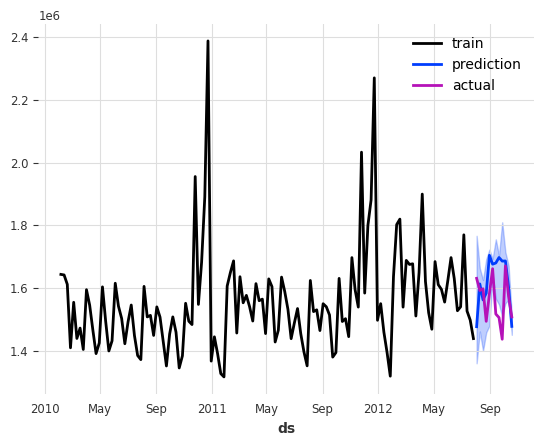

In [20]:
plotQuantile()

## (4) CatBoost

### (4.1) CatBoost - point estimate

In [21]:
from darts.models import CatBoostModel
n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)> Size: 96B
array([[[1623710.09296099]],

       [[1618556.92612083]],

       [[1638724.84930259]],

       [[1688493.45449343]],

       [[1687484.56592307]],

       [[1726272.91210104]],

       [[1662904.12539692]],

       [[1720962.0088489 ]],

       [[1685520.28526041]],

       [[1690552.02955378]],

       [[1585253.56346481]],

       [[1511930.6252472 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 96B 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 8B 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None
    metadata:           None

Mean Absolute Error: 90274.0143960003
Mean Absolute Percentage Error 5.963436466086385


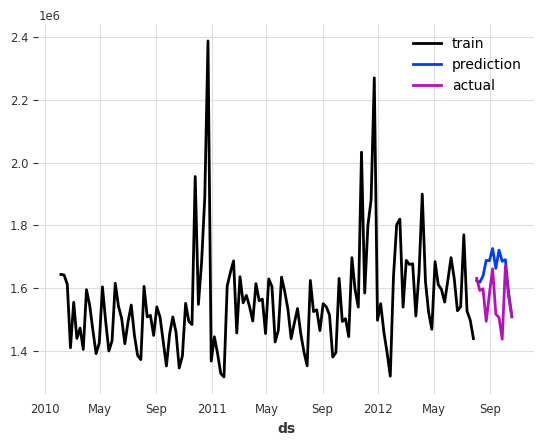

In [22]:
plotit()

### (4.2) CatBoost - quantile forecasts

In [ ]:
n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

In [ ]:
plotQuantile()